Farhad Hamidi

mrfarhadhamidi@gmail.com

## Load Dataset

This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.

But for this analysis, the dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

I don't know for sure about the dataset sharing as it's not my own data that's why I kept it private.


In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
train_dir = '../data/NEU Metal Surface Defects Data/train'
val_dir = '../data/NEU Metal Surface Defects Data/valid'
test_dir='../data/NEU Metal Surface Defects Data/test'

print("Path Direcorty: Direcorty: ",os.listdir('../data/NEU Metal Surface Defects Data'))
print("Train Direcorty: ",os.listdir(train_dir))
print("Test Direcorty: ",os.listdir(test_dir))
print("Validation Direcorty: ",os.listdir(val_dir))

Path Direcorty: Direcorty:  ['test', 'Thumbs.db', 'train', 'valid']
Train Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Test Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Validation Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


Here, you can see the dataset distribution for 'Inclusion' surface defect. Rest of the dataset also follow the same distribution



In [3]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


## Pre-processing the data


In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')



Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


Stop training the model at 99% training accuracy¶

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99 ):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

## Create Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 199, 199, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 128)       16512     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 307328)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               78676224  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [9]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 [==============================] - 182s 1s/step - loss: 2.6816 - accuracy: 0.3128 - val_loss: 3.5183 - val_accuracy: 0.1806

## visualization

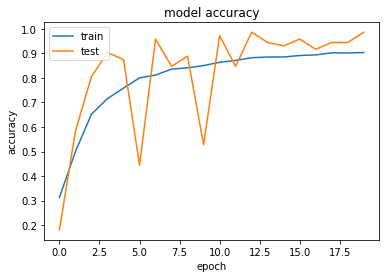

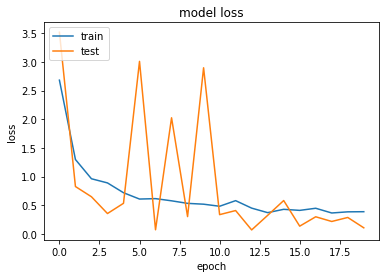

In [10]:
import matplotlib.pyplot as plt
plt.figure(1)
# summarize history for accuracy
#plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

 # summarize history for loss
plt.figure(2)

#plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test Result visualization

In [11]:
# First, we are going to load the file names and their respective target labels into numpy array!
from sklearn.datasets import load_files
import numpy as np

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)

In [12]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [13]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [14]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [15]:
x_test = x_test.astype('float32')/255

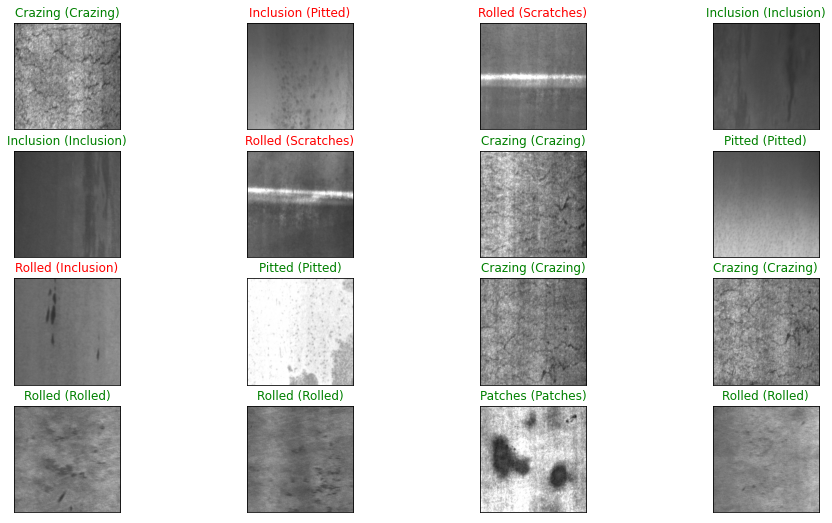

In [16]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))